In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

import warnings
warnings.filterwarnings('ignore')

У нас есть CSV-файл, в котором содержатся строки из рецептов блюд на английском языке, а также пояснения к этим рецептам. В колонке "input" у нас строка с рецептом блюда, в колонке "name" — название основного продукта в этом блюде, в колонках "quantity" и "range_end" содержится информация о количестве этого продукта в блюде, колонка "unit" отвечает за единицу измерения, колонка "комментарий" отвечает за дополнительные сведения о приготовлении блюда. 

In [2]:
df = pd.read_csv('datasets/nyt-ingredients-head.csv') # частичный dataset
df

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN
5,5,NaN,water,0.50,0.0,cup,NaN
6,6,"2 tablespoons unflavored gelatin, dissolved in...",gelatin,2.00,0.0,tablespoon,"unflavored, dissolved in 1/2 cup water"
7,7,Salt,Salt,0.00,0.0,NaN,NaN
8,8,1 cup canned plum tomatoes with juice,plum tomatoes,1.00,0.0,cup,"canned, with juice"


In [3]:
datafile = 'datasets/BIO_recipe_dataset.txt' #  весь файл с рецептами, который был переведен в формат BIO
lines    = open(datafile, encoding='utf-8').read().strip().split('\n')

In [18]:
%load_ext autoreload
%autoreload 2

from utils.recipe_utils import  calculate_micro_macro_avg, form_vocabulary_and_tagset, prepare_data, show_markup, Converter, predict_tags, tag_statistics, plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# словарь и тэги
vocabulary,labels = form_vocabulary_and_tagset(lines)

# рецепты с тегами
recipes_w_tags = prepare_data(lines)
print(recipes_w_tags[0])

len(recipes_w_tags)

(['1$1/4', 'cups', 'cooked', 'and', 'pureed', 'fresh', 'butternut', 'squash', ',', 'or', '1', '10-ounce', 'package', 'frozen', 'squash', ',', 'defrosted'], ['B-QTY', 'B-UNIT', 'B-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'B-NAME', 'I-NAME', 'OTHER', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'B-NAME', 'OTHER', 'I-COMMENT'])


49847

In [8]:
# Проверка работы энкодера и декодера
converter = Converter(vocabulary,labels)

test_recipe, test_tags = recipes_w_tags[0]

show_markup(test_recipe, test_tags)
print()

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()


decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags)


tensor([  57, 2245, 2133, 1520, 4060, 2650, 1846, 4624,   25, 3729,   42,  125,
        3771, 2668, 4624,   25, 2303])
tensor([3, 5, 0, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



In [6]:
# разделение на тестовую и тренировочную выборки
training_data = recipes_w_tags[     :40000]
test_data     = recipes_w_tags[40000:]

## LSTM

In [9]:
EMBEDDING_DIM = 64
HIDDEN_DIM    = 64
VOCAB_SIZE    = len(converter.word_with_idx)
TAGSET_SIZE   = len(converter.tag_with_idx)

In [10]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).tolist()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [11]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer     = optim.Adam(model.parameters(), lr = 0.001)

## Обучение модели

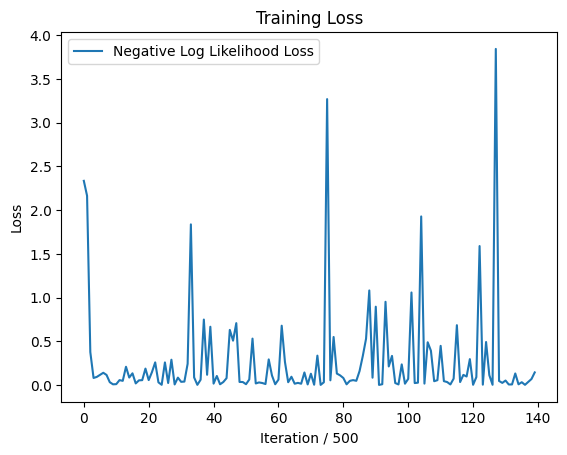

In [12]:
# Список для хранения значений потерь
loss_history = []

# Цикл обучения
for epoch in range(10): 
    for r in range(7_000):
        i = np.random.randint(0, 39_999)
        
        recipe, tags = training_data[i]
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe)  # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)     # тэг   -> его номер в списке тэгов
        
        tag_scores     = model(encoded_recipe)
        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        # Сохраняем значение потери каждые 500 итераций
        if r % 500 == 0:
            loss_value = loss.item()  # Получаем скалярное значение из тензора
            loss_history.append(loss_value)


plt.plot(loss_history, label='Negative Log Likelihood Loss')
plt.xlabel('Iteration / 500')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## Проверка работы модели на тестовых данных:

### Работа модели на случайно выбранных 5 рецептах:

In [57]:
for i in range(0,5):

    recipe, tags = test_data[np.random.randint(0,7000)]
    
    tags_pred = predict_tags(model, converter, recipe)

    print('Истинные тэги:')
    show_markup(recipe, tags)

    print('Предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

Истинные тэги:


Предсказанные тэги:



Истинные тэги:


Предсказанные тэги:



Истинные тэги:


Предсказанные тэги:



Истинные тэги:


Предсказанные тэги:



Истинные тэги:


Предсказанные тэги:


### Метрики по всем классам:

In [34]:
total_correct, total_tags, total_predicted = tag_statistics(model, converter, test_data)
metrics = calculate_micro_macro_avg(total_correct, total_tags, total_predicted)

print("Accuracy:", sum(total_correct.values()) / sum(total_tags.values()))
print("Macro-Precision:", metrics["macro_precision"])
print("Micro-Precision:", metrics["micro_precision"])
print("Macro-Recall:", metrics["macro_recall"])
print("Micro-Recall:", metrics["micro_recall"])
print("Micro-F1:", 2 * (metrics["micro_precision"] * metrics["macro_recall"]) / (metrics["micro_precision"] + metrics["macro_recall"]))


Accuracy: 0.892382290453019
Macro-Precision: 0.8947628972849693
Micro-Precision: 0.892382290453019
Macro-Recall: 0.8772457830908467
Micro-Recall: 0.892382290453019
Micro-F1: 0.8847493017412927


### Метрики по каждому классу:

In [32]:
for tag in total_tags.keys():
    print("Для {}:".format(tag))
    print("Precision:", total_correct[tag] / total_predicted[tag])
    print("Recall:", total_correct[tag] / total_tags[tag])
    print()

Для B-QTY:
Precision: 0.9740290126345343
Recall: 0.9888361045130641

Для B-COMMENT:
Precision: 0.829892221789378
Recall: 0.8169500191742298

Для B-RANGE_END:
Precision: 0.9617834394904459
Recall: 0.967948717948718

Для B-UNIT:
Precision: 0.9762437115707099
Recall: 0.9875600791631326

Для B-NAME:
Precision: 0.8830838746116916
Recall: 0.9127262113251605

Для I-NAME:
Precision: 0.9056143205858421
Recall: 0.8053545586107091

Для I-COMMENT:
Precision: 0.8708220982002884
Recall: 0.9267885744794447

Для OTHER:
Precision: 0.7566344993968637
Recall: 0.6118019995123141



### Матрица Ошибок (Confusion Matrix):

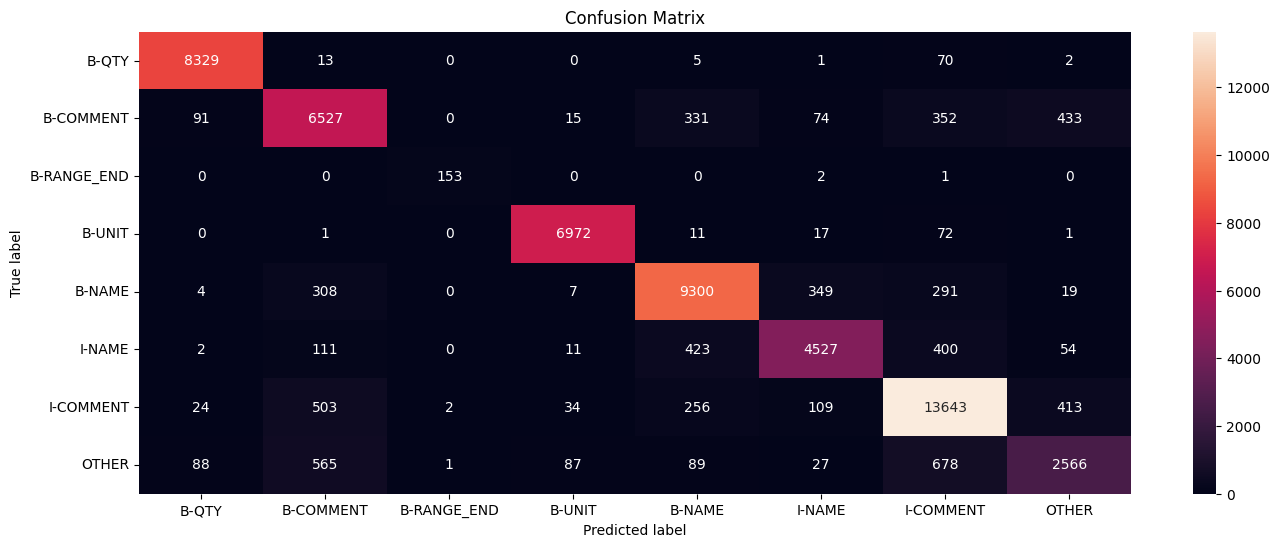

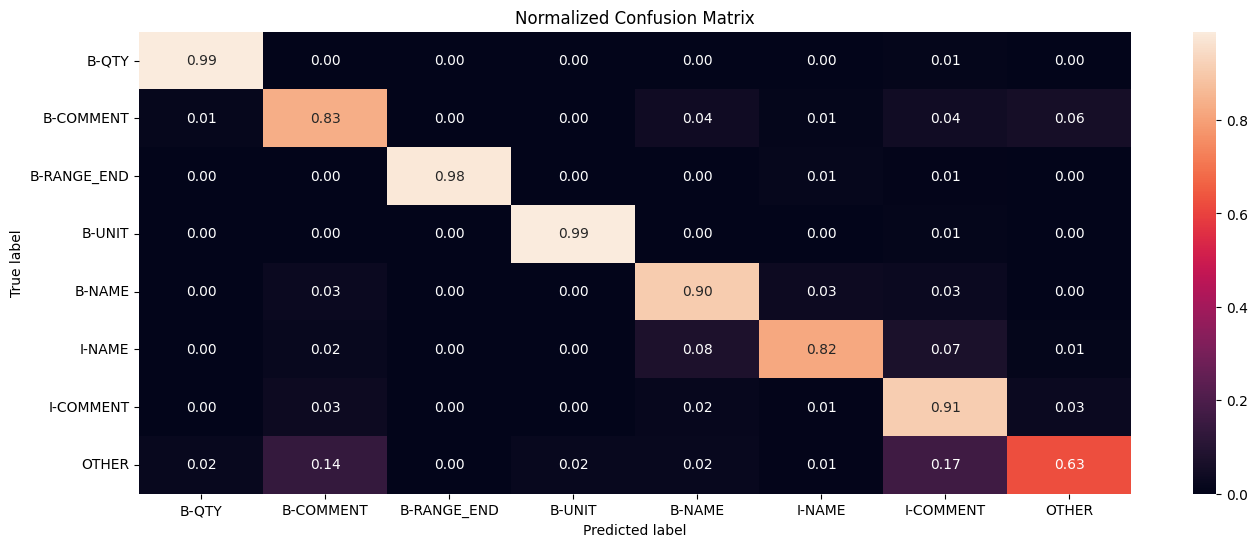

In [31]:
y_pred = []
y_true = []

for recipe, tags in test_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags
    
plot_confusion_matrix(y_true, y_pred, list(total_tags.keys()))